<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/trend-momentum-spot-analysis/update_2023/7_updated_momentum_megafactor_simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Momentum Megafactor Simulation - updated 2023

Load libraries and set chart options

In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = TRUE, extra_libraries = c('lubridate', 'glue'), extra_dependencies = c())

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




cli   (3.6.1 -> 3.6.2) [CRAN]
vctrs (0.6.4 -> 0.6.5) [CRAN]
bit   (4.0.4 -> 4.0.5) [CRAN]
cpp11 (0.4.6 -> 0.4.7) [CRAN]


Installing 4 packages: cli, vctrs, bit, cpp11

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



fansi    (1.0.5    -> 1.0.6   ) [CRAN]
processx (3.8.2    -> 3.8.3   ) [CRAN]
pkgbuild (1.4.2    -> 1.4.3   ) [CRAN]
desc     (1.4.2    -> 1.4.3   ) [CRAN]
progress (1.2.2    -> 1.2.3   ) [CRAN]
openssl  (2.0.6    -> 2.1.1   ) [CRAN]
jsonlite (1.8.7    -> 1.8.8   ) [CRAN]
curl     (5.0.2    -> 5.2.0   ) [CRAN]
gargle   (1.5.1    -> 1.5.2   ) [CRAN]
brio     (1.1.3    -> 1.1.4   ) [CRAN]
stringi  (1.8.2    -> 1.8.3   ) [CRAN]
vroom    (1.6.4    -> 1.6.5   ) [CRAN]
yaml     (2.3.7    -> 2.3.8   ) [CRAN]
testthat (3.2.0    -> 3.2.1   ) [CRAN]
arrow    (13.0.0.1 -> 14.0.0.2) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpmToYiR/remotes124535e76c5/RWLab-rwRtools-9f16cfc/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* buildin

Data uploaded to Colab manually for this notebook  
**TODO**: take care of reproducibility:
* provide data in git?
* better: function for creating megafactor from scratch

In [2]:
longshort_df <- readRDS("longshort.RDS")
head(longshort_df)

Date,Ticker,Close,weight
<date>,<chr>,<dbl>,<dbl>
2018-05-29,BNB,11.8336,0.088647545
2018-05-29,BTC,7132.4700,0.001008218
2018-05-29,ETH,520.8600,-0.179878174
2018-05-29,LTC,112.7900,0.076508018
2018-05-29,NEO,48.5400,-0.122044532
2018-05-30,BNB,12.4556,0.123941236


In [3]:
# get data and make universe

# snippet: rw data auth v.0.1
rwlab_data_auth()

# snippet: rw crypto load coincodex data v0.1
market_cap <- rwRtools::crypto_get_coincodex() %>%
  select(Ticker, Date, MarketCapUSD)

# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

#' prices: Binance hourly OHLCV spot data
create_binance_daily_snapshots <- function(prices, snapshot_hour=12) {
  prices %>%
    # retain only the data we need and ditch USDT part of Ticker
    select(Ticker, Datetime, Close) %>%
    mutate(Ticker = str_replace(Ticker, "USDT$", "")) %>%
   # take a daily snapshot at a particular time
    mutate(
      Hour = hour(Datetime),
      Date = as_date(Datetime)
    ) %>%
    filter(Hour == snapshot_hour) %>%
    select(Date, Ticker, Close)
}

#' market_cap: market cap data from coincodex
create_binance_universe <- function(prices, market_cap, n=10, min_constituents=10, stables, to_remove) {
  # Remove stablecoins and others
  prices <- prices %>%
    filter(!Ticker %in% c(stables, to_remove))

   # remove from market_cap data anything that wasn't trading on Binance or is a stable/duplicate
  binance_tickers <- pull(prices, Ticker)
  market_cap <- market_cap %>%
    filter(!Ticker %in% c(stables, to_remove)) %>%
    filter(Ticker %in% binance_tickers)

  # Get first date where we have min_constituents
  start_date <- prices %>%
    group_by(Date) %>%
    summarise(count = n()) %>%
    filter(count >= min_constituents) %>%
    summarise(mindate = min(Date)) %>%
    pull(mindate)

  start_date <- start_date + 1

  # Flag universe consitutents
  # For a given ticker/date observation, set is_index to TRUE if:
  #    - the asset was in the top 10 coins by market cap the day before
  #    - the date is on or after the date when we have min_consituents assets in our dataset
  binance_universe <- prices %>%
    # this will remove any tickers that were removed from the prices data
    left_join(market_cap, by = c("Ticker", "Date")) %>%
    # where remaining tickers are missing market cap data, fill forward
    group_by(Ticker) %>%
    arrange(Date) %>%
    fill(MarketCapUSD, .direction = "down") %>%
    na.omit() %>%
    # but we need to create a new universe based on the remaining binance tickers (not all coincodex tickers were trading on binance)
    group_by(Date) %>%
    mutate(cap_rank = row_number(desc(MarketCapUSD))) %>%
    arrange(Date) %>%
    group_by(Ticker) %>%
    mutate(is_index = lag(cap_rank) <= n & Date >= start_date) %>%
    na.omit() %>%
    ungroup()
}

# create daily snapshots
daily_prices <- prices %>%
  create_binance_daily_snapshots(snapshot_hour = 8)

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

# duplicates and others to remove
to_remove <- c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')

# create universe
min_constituents <- 10
universe <- create_binance_universe(daily_prices, market_cap, n=10, min_constituents=min_constituents, stables=stables, to_remove=to_remove)

head(universe)

Authorization successful!

ℹ Downloading coincodex_marketcap.feather

✔ Saved coincodex_marketcap.feather to coincodex/coincodex_marketcap.feather  (…





File successfully transferred


ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 831.1 Mb )





File successfully transferred


Date,Ticker,Close,MarketCapUSD,cap_rank,is_index
<date>,<chr>,<dbl>,<dbl>,<int>,<lgl>
2017-08-17,BTC,4360.69,72153449099,1,FALSE
2017-08-17,ETH,308.62,28752742413,2,FALSE
2017-08-18,BTC,4282.73,70206129858,1,FALSE
2017-08-18,ETH,304.23,28406320026,2,FALSE
2017-08-19,BTC,3999.00,67500579074,1,FALSE
2017-08-19,ETH,288.40,27839631816,2,FALSE


In [4]:
head(longshort_df)

Date,Ticker,Close,weight
<date>,<chr>,<dbl>,<dbl>
2018-05-29,BNB,11.8336,0.088647545
2018-05-29,BTC,7132.4700,0.001008218
2018-05-29,ETH,520.8600,-0.179878174
2018-05-29,LTC,112.7900,0.076508018
2018-05-29,NEO,48.5400,-0.122044532
2018-05-30,BNB,12.4556,0.123941236


In [5]:
tail(longshort_df)

Date,Ticker,Close,weight
<date>,<chr>,<dbl>,<dbl>
2023-12-07,DOGE,0.09535,0.08932252
2023-12-07,ETH,2245.34000,0.05036852
2023-12-07,LINK,15.41700,-0.02112154
2023-12-07,SOL,62.69000,0.01710950
2023-12-07,TRX,0.10440,-0.05353530
2023-12-07,XRP,0.63800,-0.02619412


In [11]:
# get all tickers that were ever in the universe
universe_tickers <- universe %>%
  filter(is_index == TRUE) %>%
  pull(Ticker) %>%
  unique()

print(universe_tickers)

# get start date of simulation (first time we have min constituents)
start_date <- universe %>%
  filter(is_index == TRUE) %>%
  group_by(Date) %>%
  summarise(num_tickers = n()) %>%
  filter(num_tickers >= min_constituents) %>%
  summarise(start_date = first(Date)) %>%
  pull(start_date)

end_date <- longshort_df %>% tail(1) %>% pull(Date)

sim_df <- longshort_df %>%
  select(Date, Ticker, Close, weight) %>%
  # bind prices on days where our universe tickers weren't in the tradable universe
  # this will assign NA to any combo_weight where the ticker wasn't traded
  bind_rows(
    universe %>%
      filter(Ticker %in% universe_tickers, is_index == FALSE) %>%
      select(Date, Ticker, Close)
  ) %>%
  # assign 0 for any NA weight
  replace_na(list(weight = 0)) %>%
  # sort by date
  arrange(Date, Ticker) %>%
  # remove rows prior to start date
  filter(Date >= start_date) %>%
  filter(Date <= end_date)

sim_df <- sim_df %>%
  group_by(Date, Ticker) %>%
  summarise(Close = first(Close), weight = max(weight))

head(sim_df)

 [1] "ADA"   "BNB"   "BTC"   "EOS"   "ETH"   "LTC"   "NEO"   "QTUM"  "XRP"  
[10] "XLM"   "ONT"   "TRX"   "ETC"   "BCHSV" "XMR"   "LINK"  "XTZ"   "BCH"  
[19] "DASH"  "DOT"   "DOGE"  "THETA" "FIL"   "UNI"   "ICP"   "SOL"   "AVAX" 
[28] "FLOW"  "SHIB"  "MATIC"


`summarise()` has grouped output by 'Date'. You can override using the
`.groups` argument.


Date,Ticker,Close,weight
<date>,<chr>,<dbl>,<dbl>
2018-06-02,BNB,14.2892,0.252567703
2018-06-02,BTC,7662.0300,-0.041046465
2018-06-02,ETH,595.2700,-0.176875597
2018-06-02,LTC,123.6900,-0.079021752
2018-06-02,NEO,56.9000,-0.001322261
2018-06-03,BNB,14.9692,0.272106956


Make wide matrixes of prices and weights

In [13]:
# get weights as a wide matrix (could do equal weight, in proportion to factor/signal, top n etc)
# note that date column will get converted to unix timestamp
backtest_weights <- sim_df %>%
  pivot_wider(names_from = Ticker, values_from = c(Close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("weight_")) %>%
  data.matrix()

# NA weights should be zero
backtest_weights[is.na(backtest_weights)] <- 0

head(backtest_weights, c(5, 5))

# get prices as a wide matrix
# note that date column will get converted to unix timestamp
backtest_prices <- sim_df %>%
  pivot_wider(names_from = Ticker, values_from = c(Close, weight)) %>%  # pivot wider guarantees prices and theo_weight are date aligned
  select(Date, starts_with("Close_")) %>%
  data.matrix()

head(backtest_prices, c(5, 5))

Date,weight_BNB,weight_BTC,weight_ETH,weight_LTC
17684,0.2525677,-0.041046465,-0.176875597,-0.079021752
17685,0.2721070,-0.137588220,-0.131091913,-0.008459837
17686,0.2620535,-0.060139939,-0.058503649,-0.087119413
17687,0.2723261,-0.087605670,-0.015814479,-0.172864810
17688,0.2663786,0.004256576,0.001754596,-0.124479625


Date,Close_BNB,Close_BTC,Close_ETH,Close_LTC
17684,14.2892,7662.03,595.27,123.69
17685,14.9692,7755.25,624.00,127.75
17686,13.9405,7609.24,605.97,122.35
17687,14.5640,7456.47,594.01,118.52
17688,16.5156,7617.00,603.65,121.20


Helper functions and objects

In [14]:
# fees - reasonable approximation of actual costs (spread + market impact + commission)
fees <- tribble(
  ~tier, ~fee,
  0, 0.,  # use for cost-free simulations
  1, 0.0010,
  2, 0.0015,
  3, 0.0020,
  4, 0.0025,
  5, 0.0030,
  6, 0.0035,
  7, 0.0040
)

# plot equity curve from output of simulation
plot_results <- function(backtest_results, weighting_protocol = "Long-short in proportion to factor rank", trade_on = "close") {
  equity_curve <- backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE))

  fin_eq <- equity_curve %>%
    tail(1) %>%
    pull(Equity)

  init_eq <- equity_curve %>%
    head(1) %>%
    pull(Equity)

  total_return <- (fin_eq/init_eq - 1) * 100
  days <- nrow(equity_curve)
  ann_return <- total_return * 365/days
  sharpe <- equity_curve %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()

  equity_curve %>%
    ggplot(aes(x = Date, y = Equity)) +
      geom_line() +
      labs(
        title = "Momentum Backtest - Cash Accounting",
        subtitle = glue(
          "{weighting_protocol}, costs {commission_pct*100}% trade value, trade buffer = {trade_buffer}, trade on {trade_on}
          {round(total_return, 1)}% total return, {round(ann_return, 1)}% annualised, Sharpe {round(sharpe, 2)}"
        )
      )
}

# calculate sharpe ratio from output of simulation
calc_sharpe <- function(backtest_results) {
  backtest_results %>%
    group_by(Date) %>%
    summarise(Equity = sum(Value, na.rm = TRUE)) %>%
    mutate(returns = Equity/lag(Equity)- 1) %>%
    na.omit() %>%
    summarise(sharpe = sqrt(355)*mean(returns)/sd(returns)) %>%
    pull()
}

## Long - Short Simulations

### Cost free, no trade buffer parameter


ticker,Date,Close,Position,Value,Trades,TradeValue,Commission
<chr>,<date>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cash,2018-06-02,1.0000,1.045698e+04,10456.98371,NA,NA,0
BNB,2018-06-02,14.2892,1.767543e+02,2525.67703,176.75426433,2525.67703,0
BTC,2018-06-02,7662.0300,-5.357127e-02,-410.46465,-0.05357127,-410.46465,0
ETH,2018-06-02,595.2700,-2.971351e+00,-1768.75597,-2.97135076,-1768.75597,0
LTC,2018-06-02,123.6900,-6.388694e+00,-790.21752,-6.38869364,-790.21752,0
NEO,2018-06-02,56.9000,-2.323832e-01,-13.22261,-0.23238324,-13.22261,0


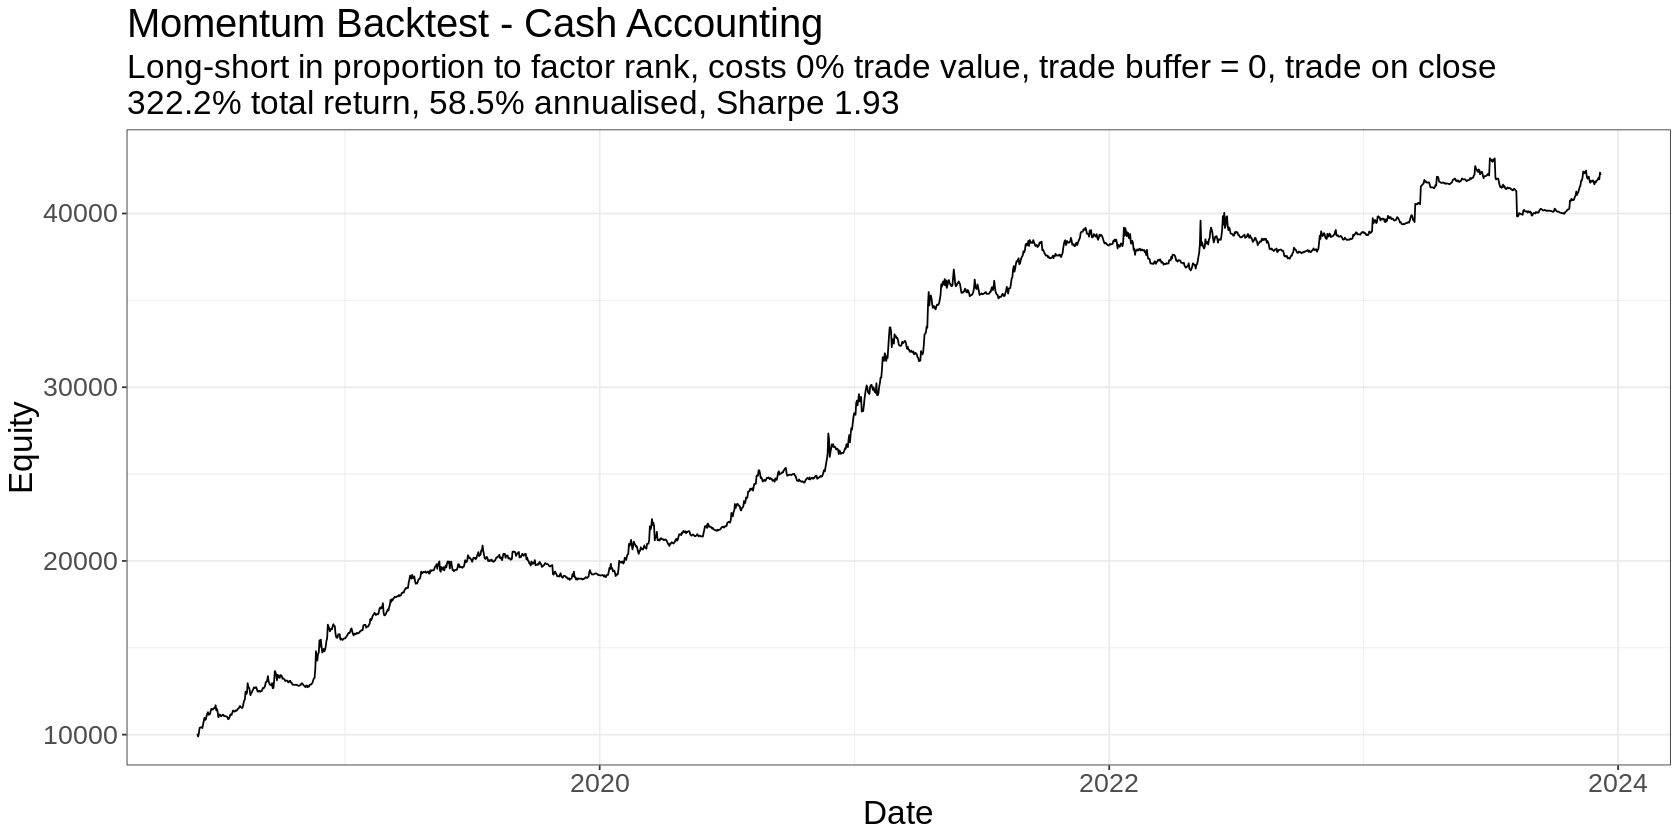

In [15]:
# simulation parameters
initial_cash <- 10000
capitalise_profits <- FALSE  # remain fully invested?
trade_buffer <- 0.
fee_tier <- 0.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
results_df <- cash_backtest(backtest_prices, backtest_weights, trade_buffer, initial_cash, commission_pct, capitalise_profits) %>%
  mutate(ticker = str_remove(ticker, "Close_"))

head(results_df)

plot_results(results_df)

### With costs, no trade buffer parameter

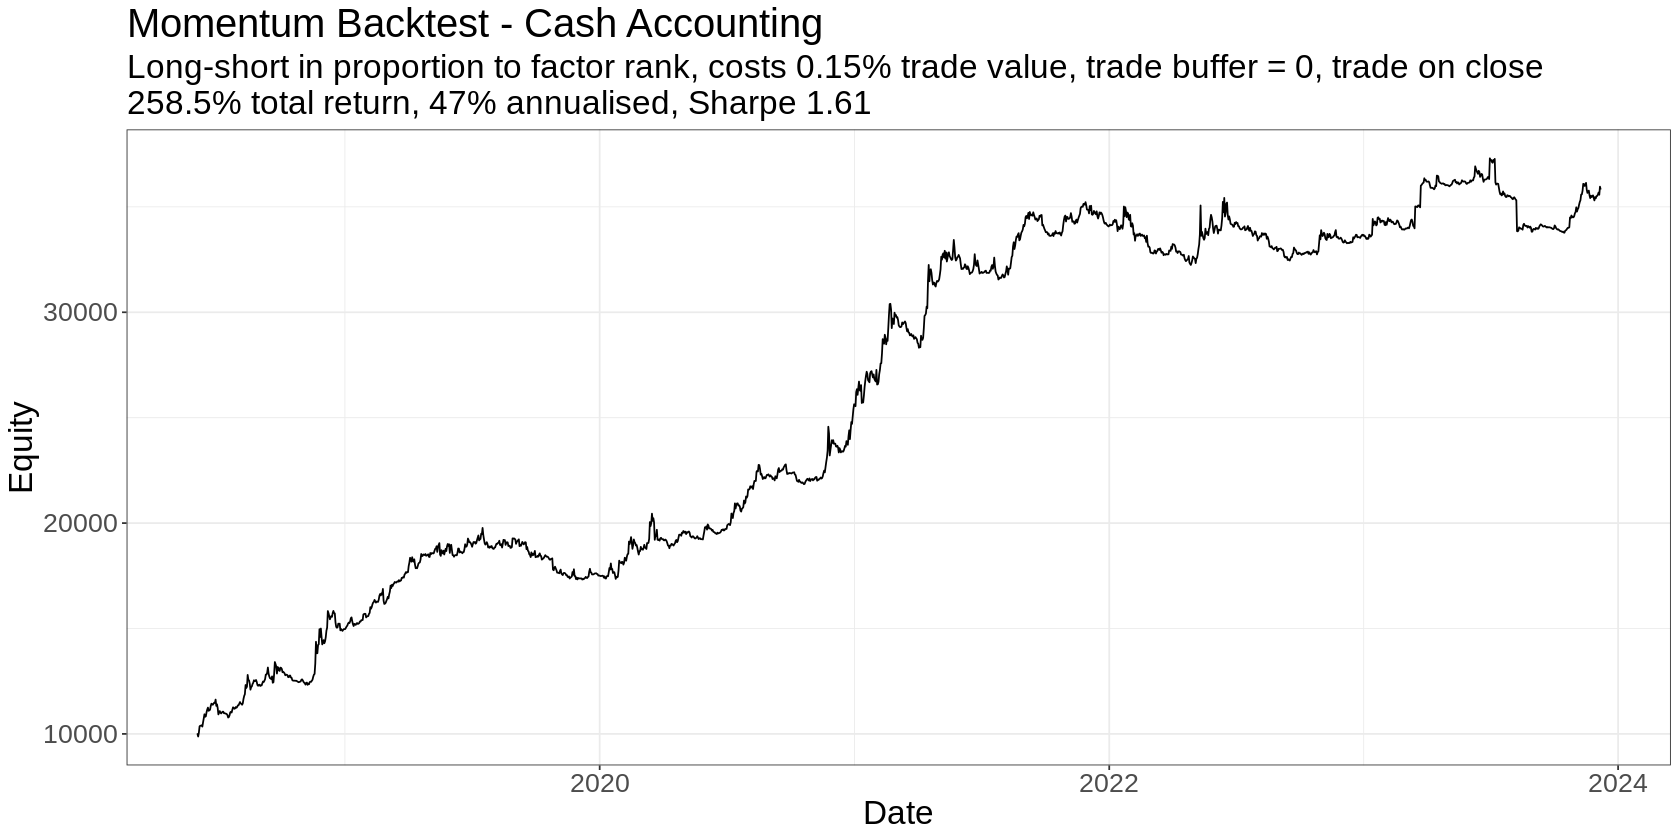

In [16]:
# simulation parameters
fee_tier <- 2.
commission_pct <- fees$fee[fees$tier==fee_tier]

# simulation
cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
) %>%
  plot_results()

Find an appropriate trade buffer parameter by optimising for sharpe ratio

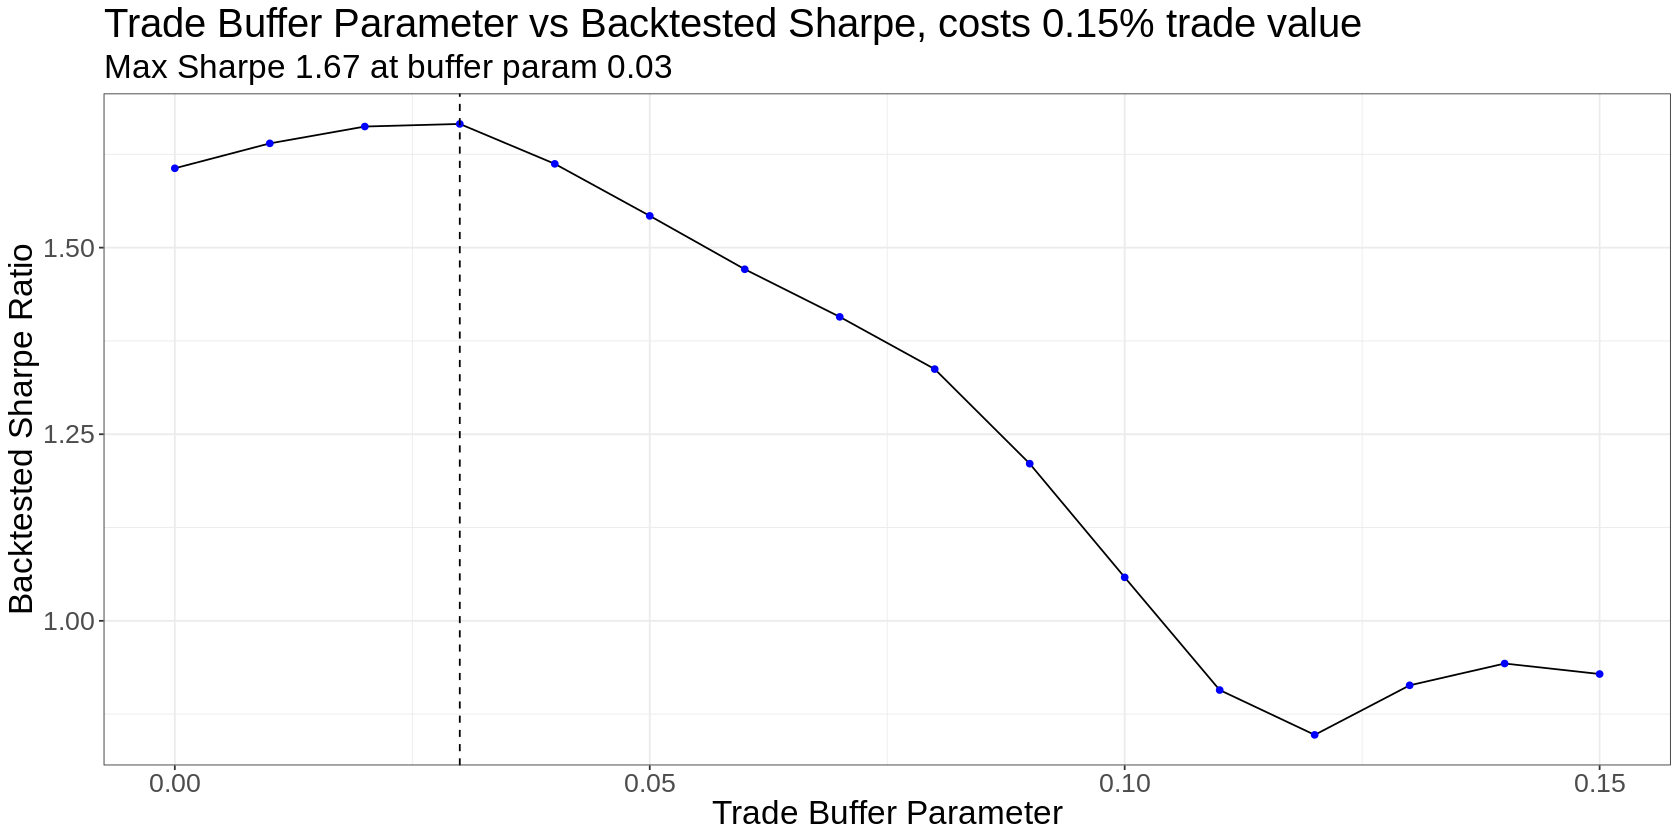

In [17]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      backtest_weights,
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

### Backtest with optimal trade buffer

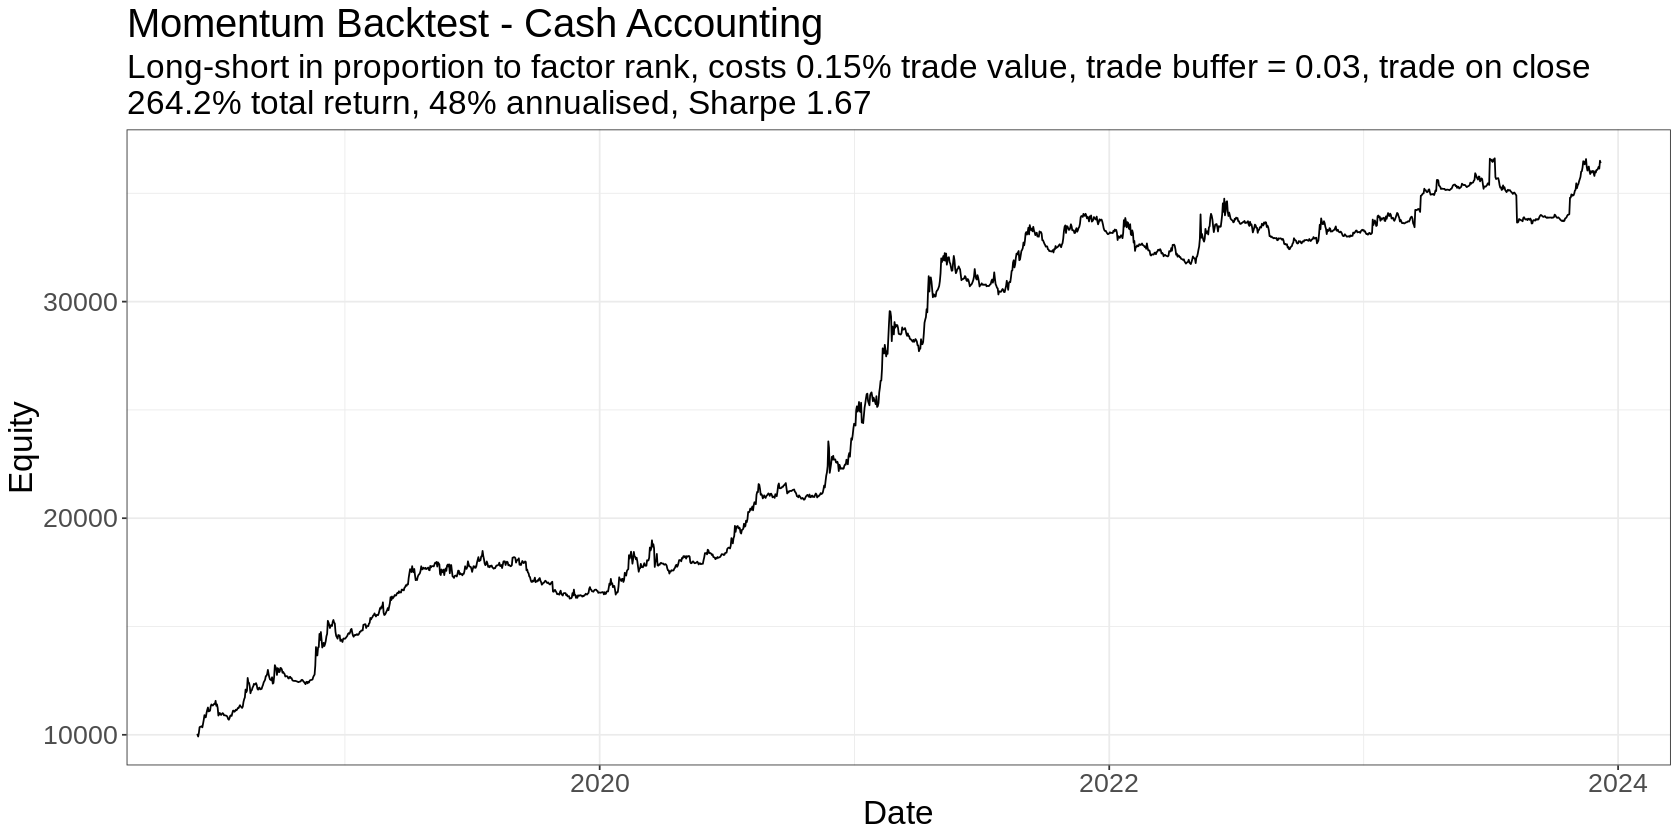

In [18]:
trade_buffer <- 0.03

cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
) %>%
plot_results()

### What if we trade on the next day's close?


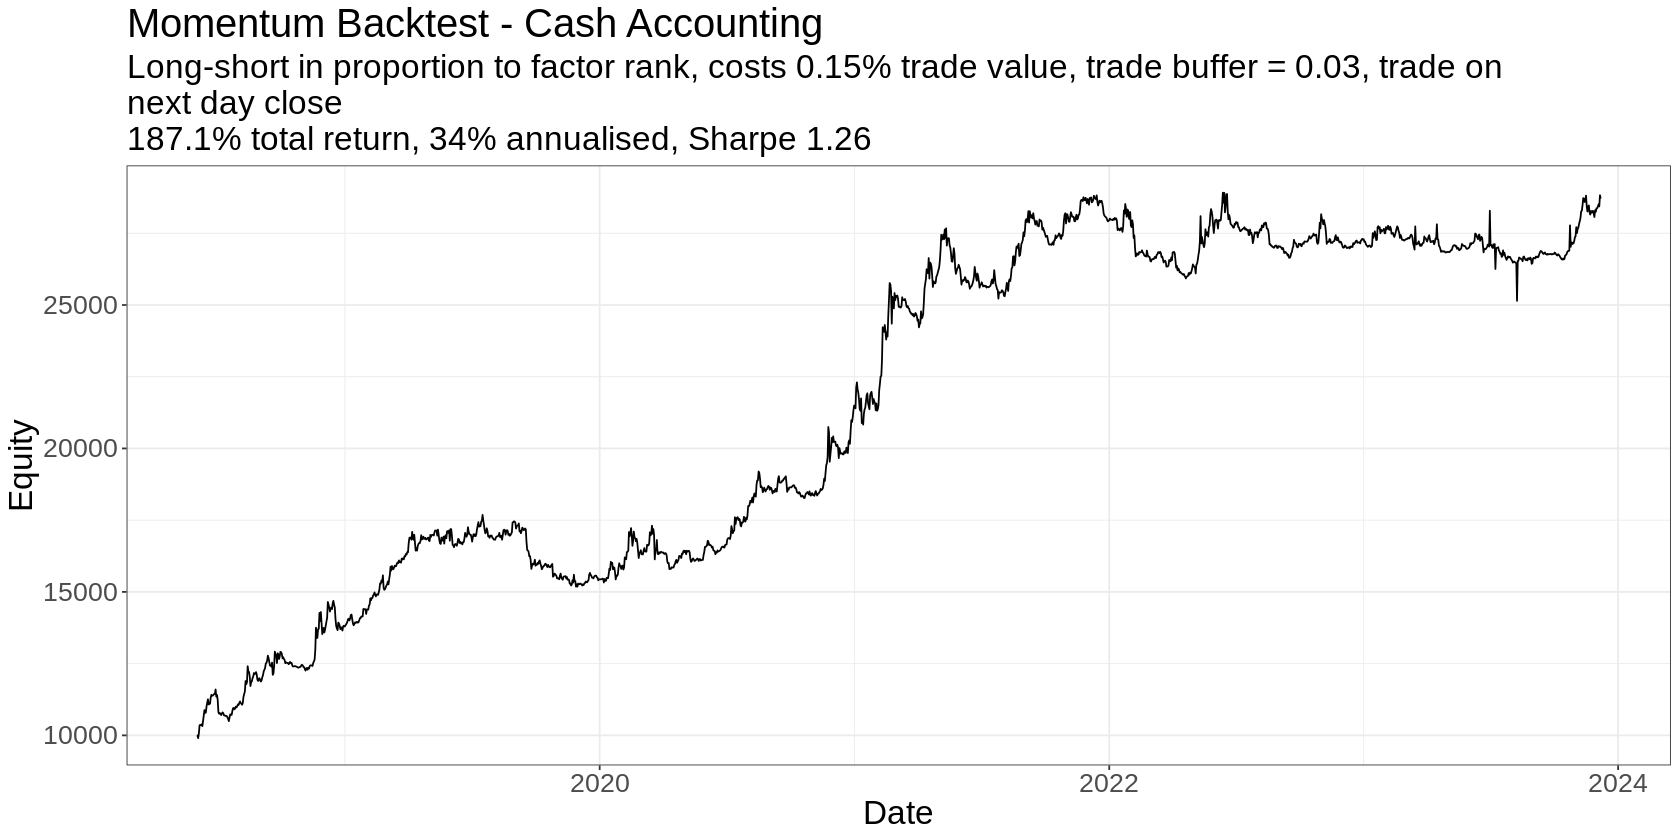

In [19]:
cash_backtest(
  backtest_prices,
  # lag backtest weights with respect to prices
  backtest_weights %>%
    as.data.frame() %>%
    mutate(across(.cols = -Date, .fns = \(x) dplyr::lag(x, n = 1))) %>%
    data.matrix(),
  trade_buffer,
  initial_cash,
  commission_pct,
  capitalise_profits
) %>%
  plot_results(trade_on = "\nnext day close")

Is there a different trade buffer trade-off if we assume trading on the next day's close?


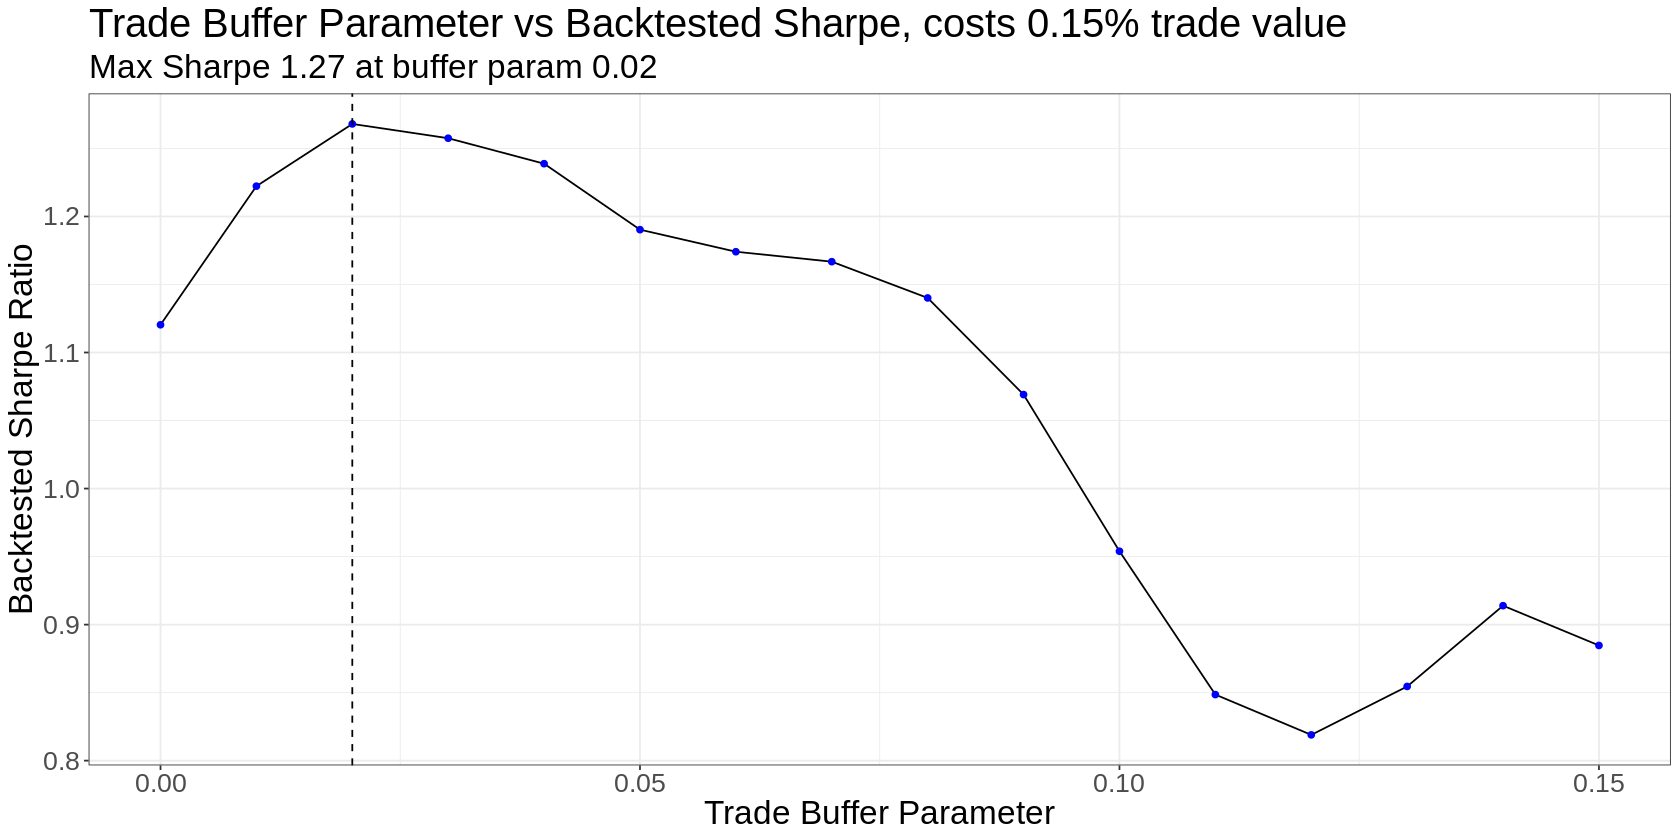

In [20]:
sharpes <- list()
trade_buffers <- seq(0, 0.15, by = 0.01)
for(trade_buffer in trade_buffers) {
  sharpes <- c(
    sharpes,
    cash_backtest(
      backtest_prices,
      # lag backtest weights with respect to prices
      backtest_weights %>%
        as.data.frame() %>%
        mutate(across(.cols = -Date, .fns = \(x) dplyr::lag(x, n = 1))) %>%
        data.matrix(),
      trade_buffer,
      initial_cash,
      commission_pct,
      capitalise_profits
    ) %>%
      calc_sharpe()
  )
}

sharpes <- unlist(sharpes)
data.frame(
  trade_buffer = trade_buffers,
  sharpe = sharpes
) %>%
  ggplot(aes(x = trade_buffer, y = sharpe)) +
    geom_line() +
    geom_point(colour = "blue") +
    geom_vline(xintercept = trade_buffers[which.max(sharpes)], linetype = "dashed") +
    labs(
      x = "Trade Buffer Parameter",
      y = "Backtested Sharpe Ratio",
      title = glue("Trade Buffer Parameter vs Backtested Sharpe, costs {commission_pct*100}% trade value"),
      subtitle = glue("Max Sharpe {round(max(sharpes), 2)} at buffer param {trade_buffers[which.max(sharpes)]}")
    )

Let's pick the optimal value and simulate:

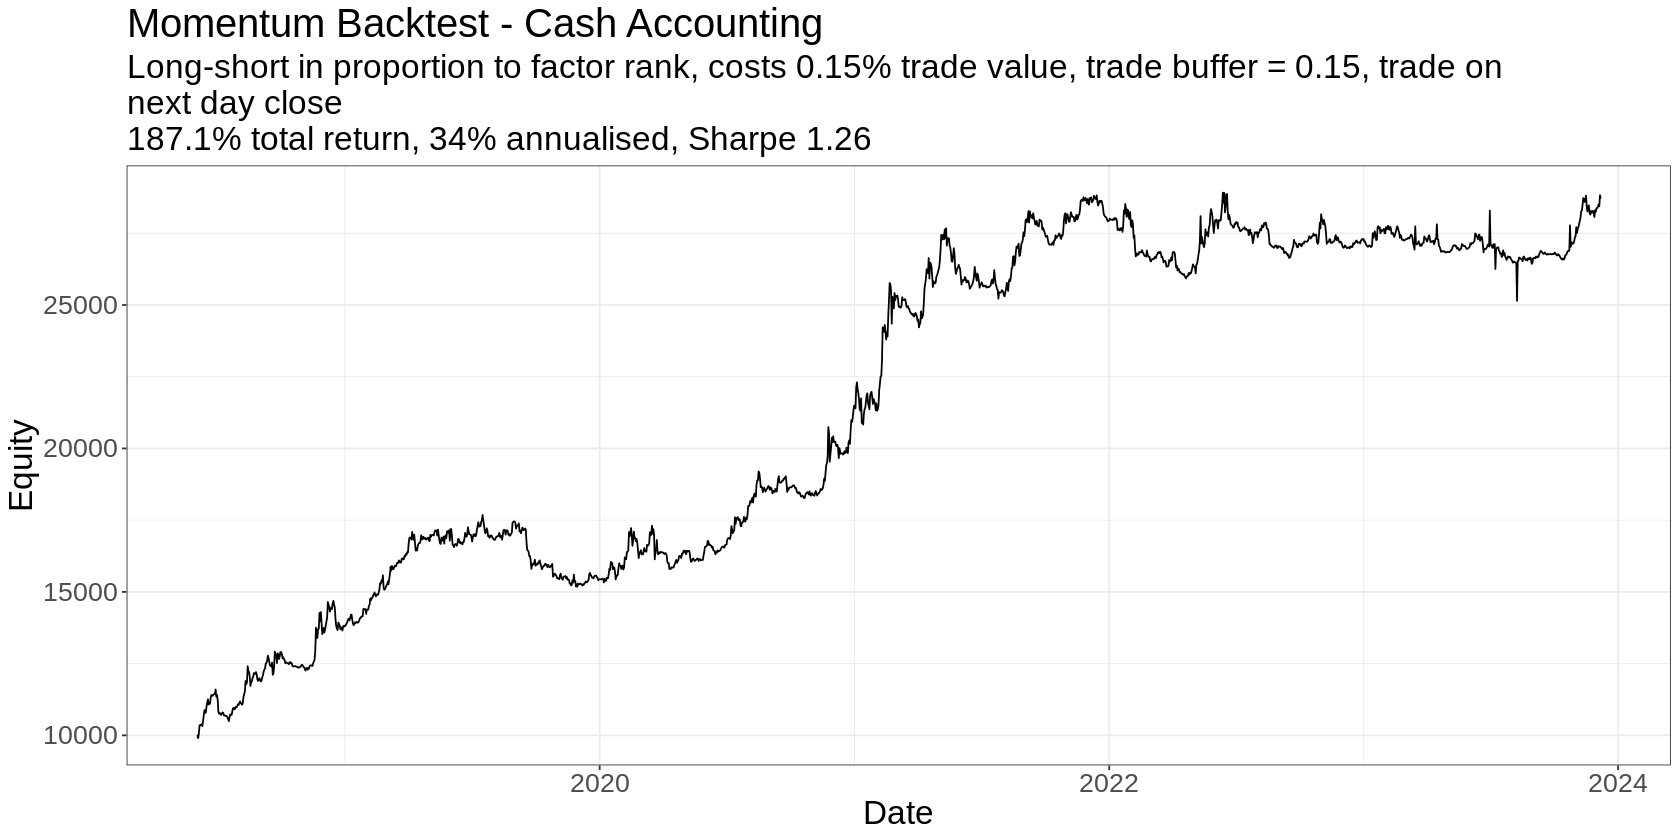

In [21]:
results_df <- cash_backtest(
  backtest_prices,
  # lag backtest weights with respect to prices
  backtest_weights %>%
    as.data.frame() %>%
    mutate(across(.cols = -Date, .fns = \(x) dplyr::lag(x, n = 1))) %>%
    data.matrix(),
  trade_buffer = 0.03,
  initial_cash,
  commission_pct,
  capitalise_profits
)
plot_results(results_df, trade_on = "\nnext day close")

Check how much we trade - use traded value by coin by date

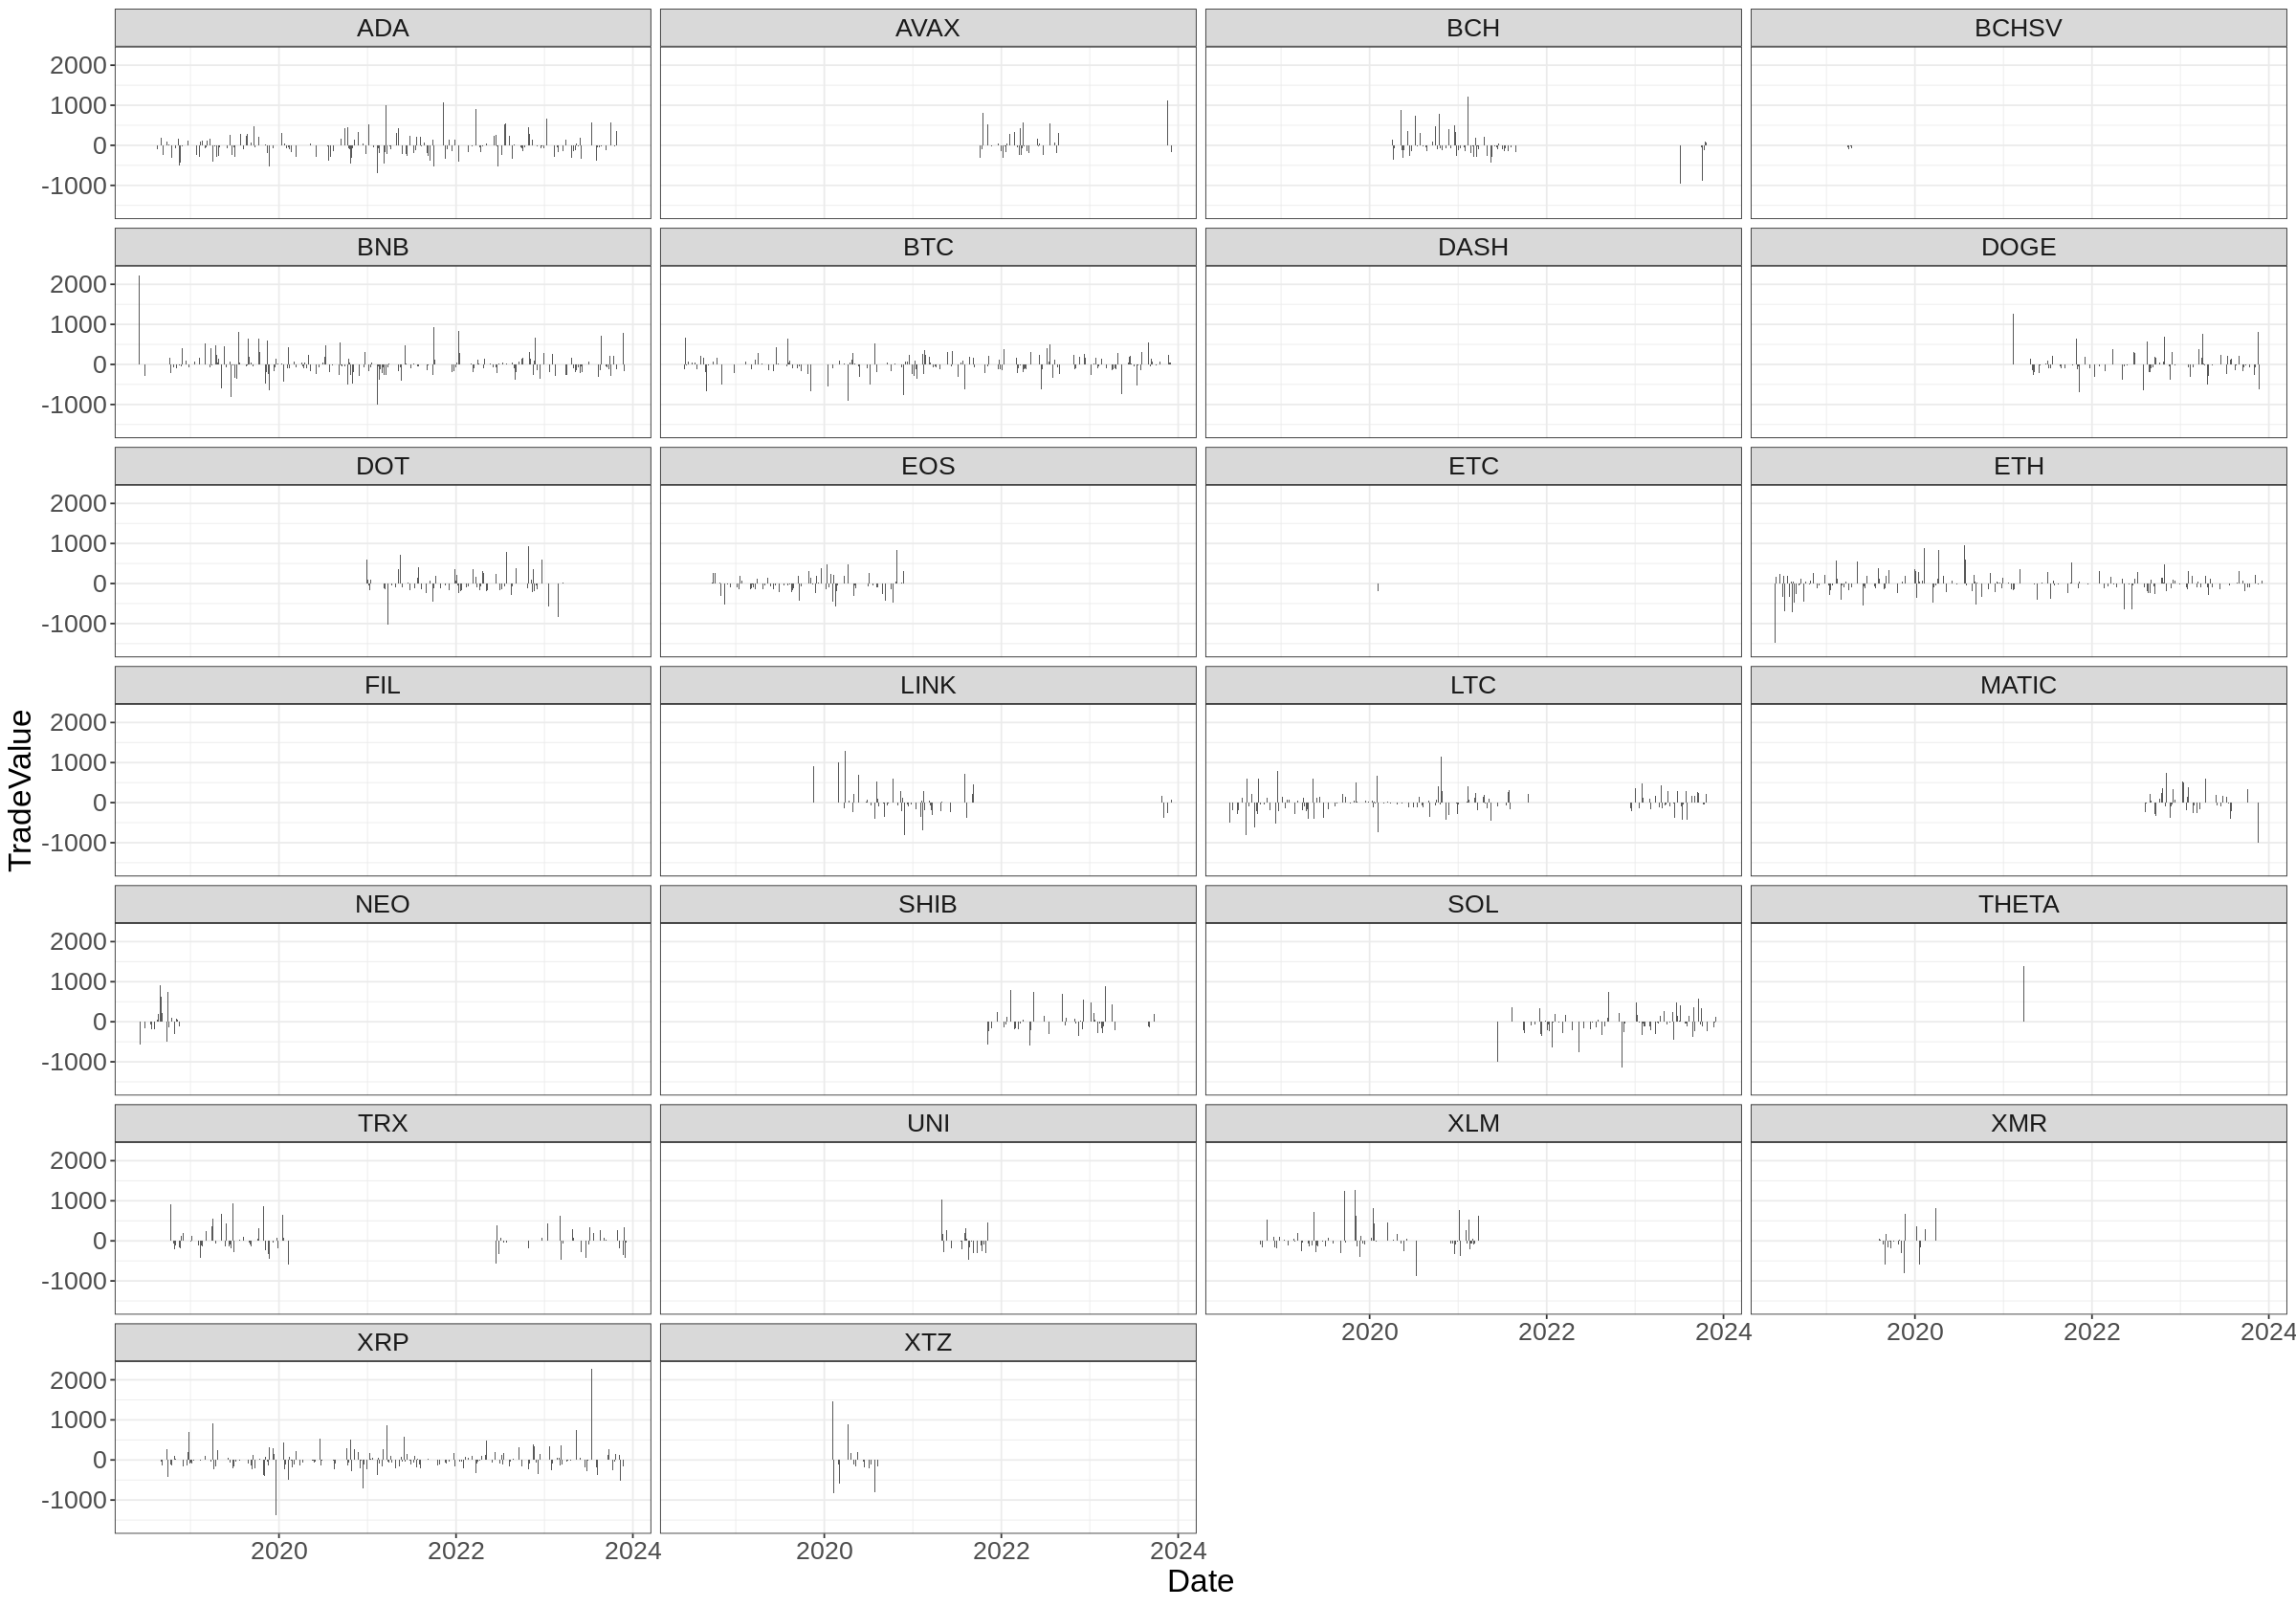

In [22]:
# need a bigger plot
options(repr.plot.width = 20, repr.plot.height=14)

results_df %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  filter(ticker != "Cash", abs(TradeValue) > 0) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 4)

# set back to default
options(repr.plot.width = 14, repr.plot.height=7)

Major coins:

Warning message:
“Removed 578 rows containing missing values (`position_stack()`).”


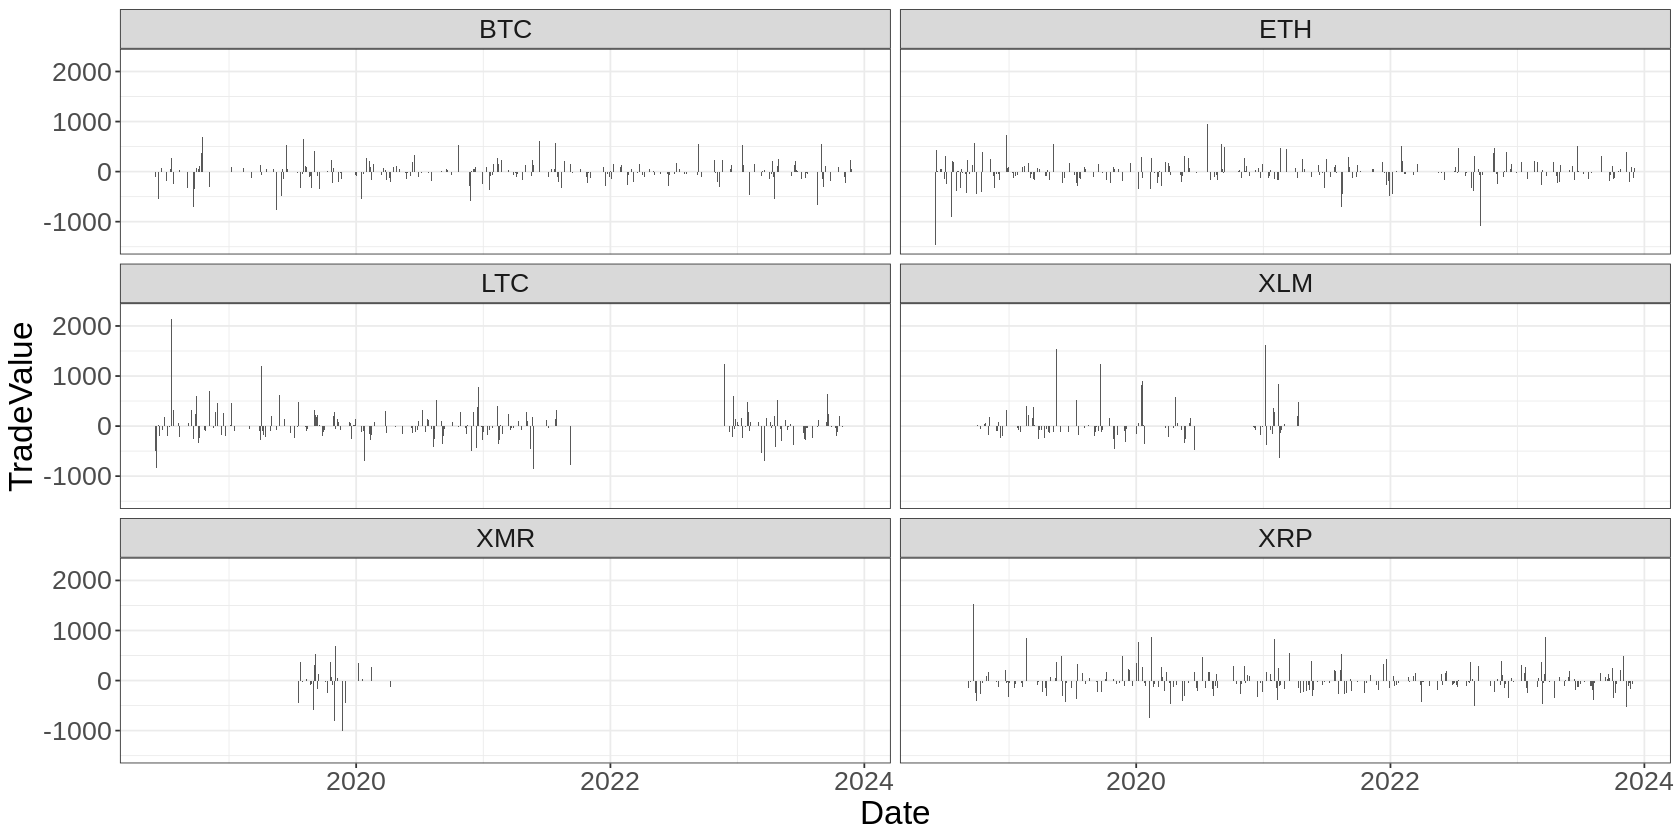

In [23]:
results_df %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  filter(ticker %in% c("BTC", "ETH", "LTC", "XLM", "XMR", "XRP")) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Zoomed in to a month:

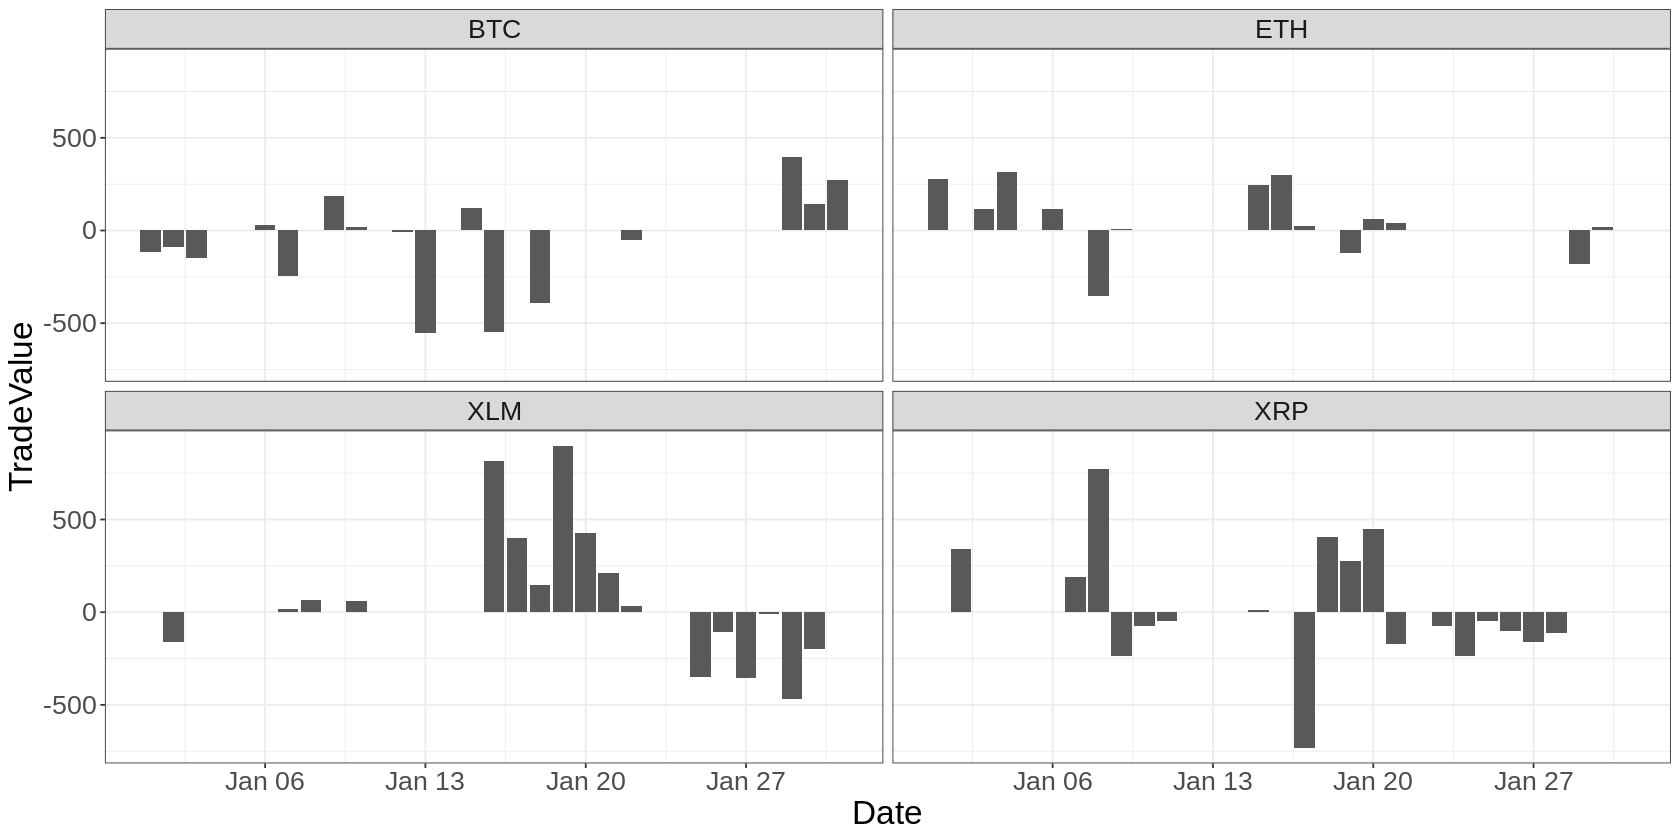

In [24]:
results_df %>%
  mutate(ticker = str_remove(ticker, "Close_")) %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"),
    Date >= "2020-01-01",
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)

Compare with no trade buffer:

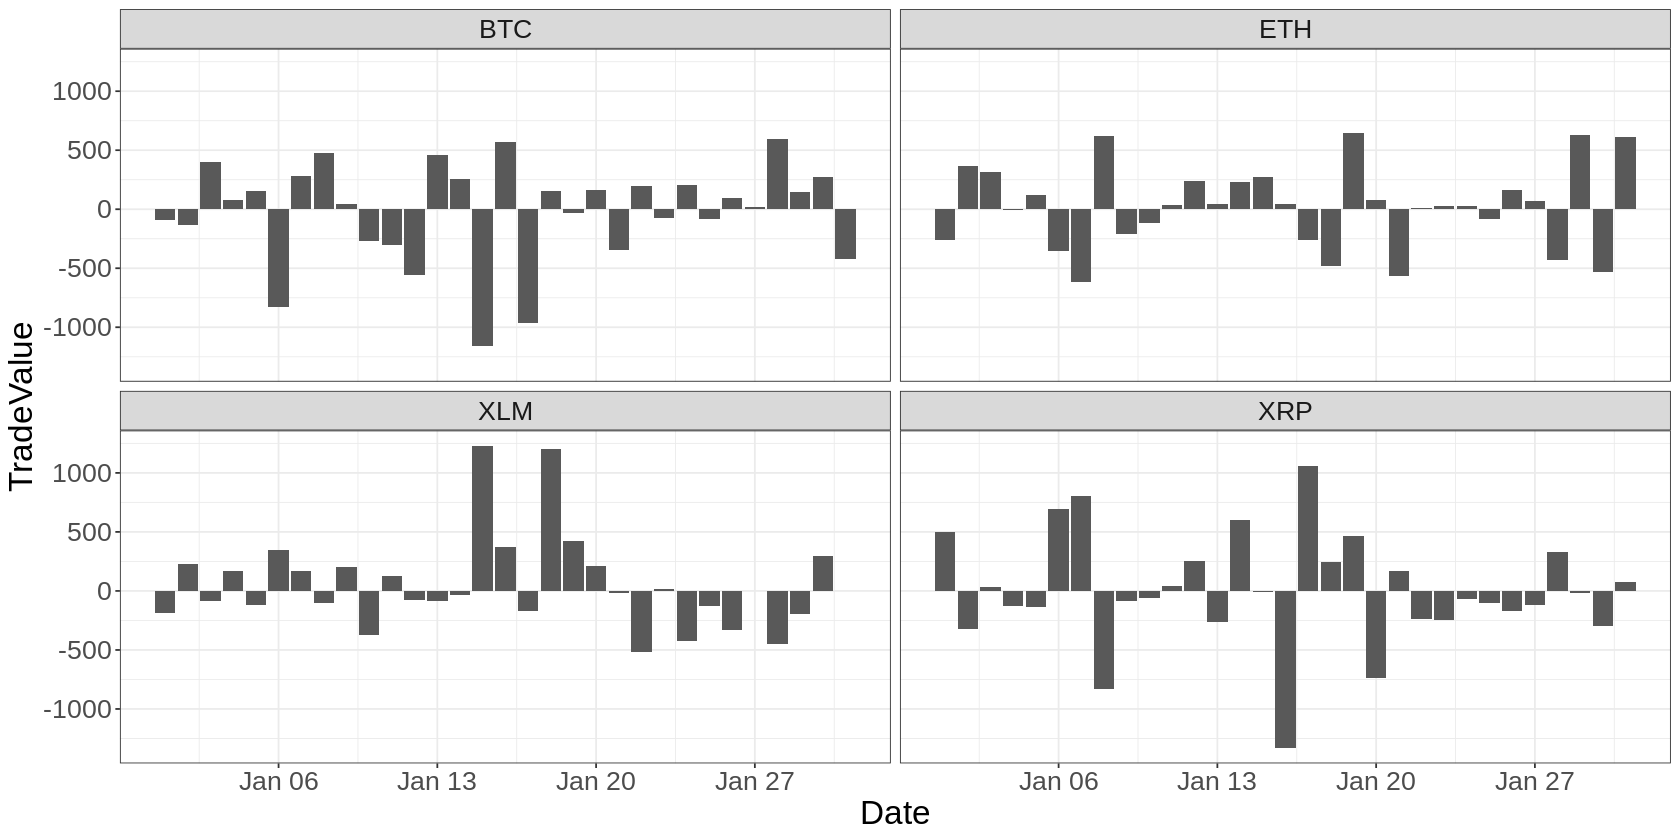

In [25]:
results_df <- cash_backtest(
  backtest_prices,
  backtest_weights,
  trade_buffer = 0.,
  initial_cash,
  commission_pct,
  capitalise_profits
) %>%
  mutate(ticker = str_remove(ticker, "Close_"))

results_df %>%
  filter(
    ticker %in% c("BTC", "ETH", "XLM", "XRP"),
    Date >= "2020-01-01",
    Date < "2020-02-01"
  ) %>%
  ggplot(aes(x = Date, y = TradeValue)) +
    geom_bar(stat = "identity") +
    facet_wrap(~ticker, ncol = 2)